# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

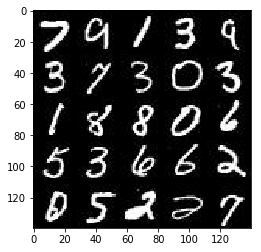

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

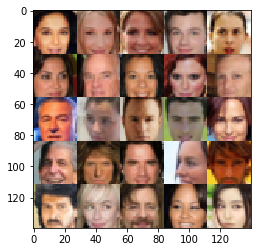

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learining_rate = tf.placeholder(tf.float32, shape=())
    
    return input_real, input_z, learining_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        # images size  28,28, color_channels

        input_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        input_layer = tf.maximum(input_layer*alpha, input_layer)
        # images size  14,14, 64

        hl1 = tf.layers.conv2d(input_layer, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        hl1 = tf.layers.dropout(hl1, rate=0.2)
        hl1 = tf.layers.batch_normalization(hl1, training=True)
        hl1 = tf.maximum(hl1* alpha, hl1)
        # image size 7,7,128
        
        hl2 = tf.layers.conv2d(hl1, 256, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        hl2 = tf.layers.dropout(hl2, rate=0.2)
        hl2 = tf.layers.batch_normalization(hl2, training=True)
        hl2 = tf.maximum(hl2* alpha, hl2)
        # image size 7,7,256        
        

        flat = tf.reshape(hl2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)


        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):

    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.1

        input_layer=tf.layers.dense(z, 7*7*512)
        l1 = tf.reshape(input_layer, (-1, 7,7,512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(l1*alpha, l1)
        # image size 7x7x512

        l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides=2, padding='same')
        l2 = tf.layers.dropout(l2, rate=0.2)
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(l2*alpha, l2)
        # image size 14x14x256
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.dropout(l3, rate=0.2)        
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(l3*alpha, l3)
        # image size 28x28x128
        
        l4 = tf.layers.conv2d_transpose(l3, 64, 5, strides=1, padding='same')
        l4 = tf.layers.dropout(l4, rate=0.2) 
        l4 = tf.layers.batch_normalization(l4, training=is_train)
        l4 = tf.maximum(alpha*l4, l4)
        #now 28x28x64        
        

        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides=1, padding='same')
        # image size 28x28xout_channel_dim

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    
    g_model = generator(input_z, out_channel_dim)
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=0.9*tf.ones_like(d_out_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_out_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
   
    n, image_width, image_height, image_channels = data_shape  
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
     
    steps = 0
    print_every = 100
    
    # -------------------------------------------------------------------------------------------

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                batch_images *= 2
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, 
                                                input_z: batch_z, 
                                                l_rate: learning_rate})

                two = sess.run(g_train_opt, feed_dict = {input_real: batch_images,
                                                input_z: batch_z,
                                                l_rate: learning_rate})

                if steps % print_every == 0:                    
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)
                if steps % (print_every/5) == 0:
                    training_d_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    training_g_loss = g_loss.eval({input_z: batch_z})
                    print("Discriminator Loss: {:.4f}".format(training_d_loss),
                             "Generator Loss: {:.4f}".format(training_g_loss))
                    



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Discriminator Loss: 0.7694 Generator Loss: 1.2640
Discriminator Loss: 0.7777 Generator Loss: 1.4867
Discriminator Loss: 0.7556 Generator Loss: 1.2964
Discriminator Loss: 1.2554 Generator Loss: 1.0169


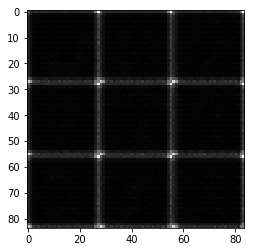

Discriminator Loss: 1.3814 Generator Loss: 0.6309
Discriminator Loss: 1.2571 Generator Loss: 0.7865
Discriminator Loss: 1.5013 Generator Loss: 0.5971
Discriminator Loss: 1.3046 Generator Loss: 0.7185
Discriminator Loss: 1.1889 Generator Loss: 0.9299


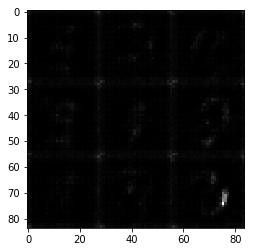

Discriminator Loss: 1.2368 Generator Loss: 0.8904
Discriminator Loss: 1.0990 Generator Loss: 1.3077
Discriminator Loss: 1.0893 Generator Loss: 1.4302
Discriminator Loss: 1.0898 Generator Loss: 1.0708
Discriminator Loss: 0.9835 Generator Loss: 1.1458


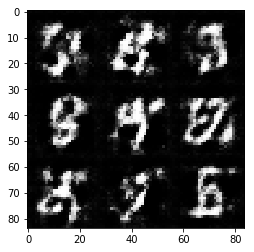

Discriminator Loss: 0.9305 Generator Loss: 1.2209
Discriminator Loss: 0.9842 Generator Loss: 0.9295
Discriminator Loss: 0.9687 Generator Loss: 0.9552
Discriminator Loss: 1.2391 Generator Loss: 0.6674
Discriminator Loss: 0.9882 Generator Loss: 1.2335


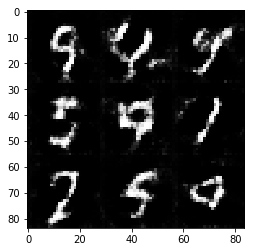

Discriminator Loss: 1.1343 Generator Loss: 0.8433
Discriminator Loss: 1.2740 Generator Loss: 0.6186
Discriminator Loss: 1.0275 Generator Loss: 0.8666
Discriminator Loss: 1.0195 Generator Loss: 1.1519
Discriminator Loss: 1.2993 Generator Loss: 0.6226


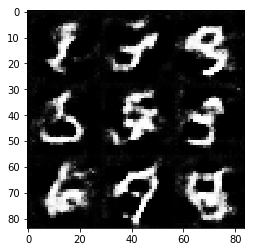

Discriminator Loss: 1.0739 Generator Loss: 1.1833
Discriminator Loss: 0.9951 Generator Loss: 1.1117
Discriminator Loss: 0.9277 Generator Loss: 1.3545
Discriminator Loss: 0.9917 Generator Loss: 1.7875
Discriminator Loss: 1.0030 Generator Loss: 1.0291


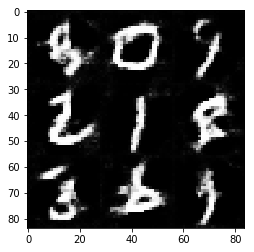

Discriminator Loss: 1.0219 Generator Loss: 1.0011
Discriminator Loss: 1.3563 Generator Loss: 1.7431
Discriminator Loss: 1.0624 Generator Loss: 0.9690
Discriminator Loss: 1.0894 Generator Loss: 0.8496
Discriminator Loss: 1.1978 Generator Loss: 0.7078


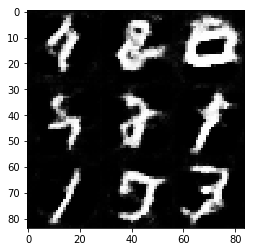

Discriminator Loss: 1.0255 Generator Loss: 0.9733
Discriminator Loss: 1.3011 Generator Loss: 0.6467
Discriminator Loss: 1.0227 Generator Loss: 1.0254
Discriminator Loss: 1.1297 Generator Loss: 0.7928
Discriminator Loss: 1.3629 Generator Loss: 0.6019


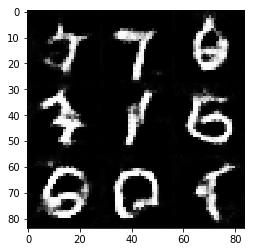

Discriminator Loss: 1.1561 Generator Loss: 1.0844
Discriminator Loss: 0.9547 Generator Loss: 1.1106
Discriminator Loss: 1.3144 Generator Loss: 0.5980
Discriminator Loss: 1.2681 Generator Loss: 0.7121
Discriminator Loss: 1.1641 Generator Loss: 0.8487


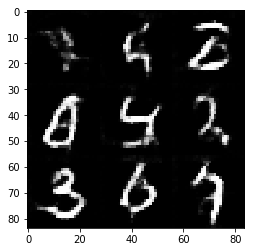

Discriminator Loss: 1.0576 Generator Loss: 0.8888
Discriminator Loss: 0.9965 Generator Loss: 0.9482
Discriminator Loss: 1.0487 Generator Loss: 0.9874
Discriminator Loss: 0.9805 Generator Loss: 1.0476
Discriminator Loss: 1.1792 Generator Loss: 0.7138


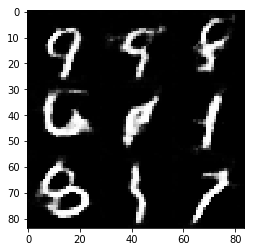

Discriminator Loss: 1.2369 Generator Loss: 0.6846
Discriminator Loss: 0.9180 Generator Loss: 1.2774
Discriminator Loss: 1.0038 Generator Loss: 1.1807
Discriminator Loss: 1.1085 Generator Loss: 0.8257
Discriminator Loss: 1.1598 Generator Loss: 0.8651


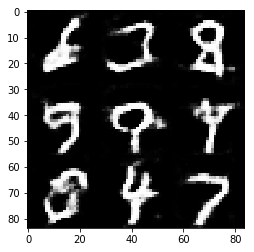

Discriminator Loss: 1.2491 Generator Loss: 0.6310
Discriminator Loss: 1.1649 Generator Loss: 1.1596
Discriminator Loss: 1.0828 Generator Loss: 1.1960
Discriminator Loss: 1.2386 Generator Loss: 0.8106
Discriminator Loss: 1.0781 Generator Loss: 1.0938


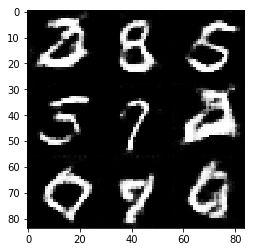

Discriminator Loss: 1.0270 Generator Loss: 0.9438
Discriminator Loss: 1.3769 Generator Loss: 0.5341
Discriminator Loss: 0.9661 Generator Loss: 1.1909
Discriminator Loss: 1.0488 Generator Loss: 1.0766
Discriminator Loss: 1.0461 Generator Loss: 1.8409


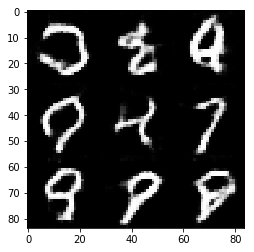

Discriminator Loss: 1.0336 Generator Loss: 1.0045
Discriminator Loss: 1.0110 Generator Loss: 1.1333
Discriminator Loss: 0.9592 Generator Loss: 1.3105
Discriminator Loss: 1.2762 Generator Loss: 0.6103
Discriminator Loss: 1.0848 Generator Loss: 0.9169


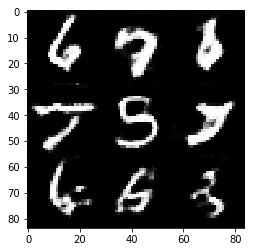

Discriminator Loss: 1.1140 Generator Loss: 0.7937
Discriminator Loss: 0.9071 Generator Loss: 1.4057
Discriminator Loss: 1.2980 Generator Loss: 0.7825
Discriminator Loss: 1.0053 Generator Loss: 1.2209
Discriminator Loss: 1.3598 Generator Loss: 0.5751


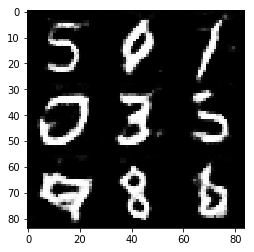

Discriminator Loss: 1.0241 Generator Loss: 0.8827
Discriminator Loss: 1.2499 Generator Loss: 0.7269
Discriminator Loss: 1.0954 Generator Loss: 1.3046
Discriminator Loss: 0.9312 Generator Loss: 1.1562
Discriminator Loss: 1.1450 Generator Loss: 0.7488


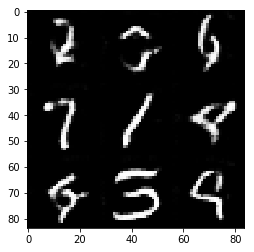

Discriminator Loss: 1.1872 Generator Loss: 0.8421
Discriminator Loss: 0.9620 Generator Loss: 1.3547
Discriminator Loss: 1.0611 Generator Loss: 0.9017
Discriminator Loss: 1.0626 Generator Loss: 0.9088
Discriminator Loss: 1.1289 Generator Loss: 0.9330


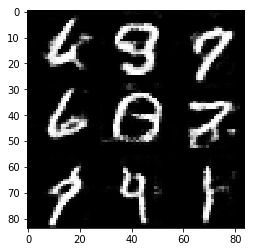

Discriminator Loss: 1.2963 Generator Loss: 0.6206
Discriminator Loss: 1.0799 Generator Loss: 0.9287
Discriminator Loss: 1.0417 Generator Loss: 1.3491
Discriminator Loss: 1.3548 Generator Loss: 0.5769
Discriminator Loss: 1.2055 Generator Loss: 0.9644


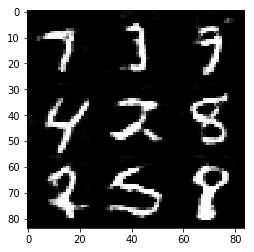

Discriminator Loss: 1.0591 Generator Loss: 1.0462
Discriminator Loss: 1.2335 Generator Loss: 0.6894
Discriminator Loss: 1.0083 Generator Loss: 1.0642
Discriminator Loss: 1.1579 Generator Loss: 0.9317
Discriminator Loss: 1.0974 Generator Loss: 0.9311


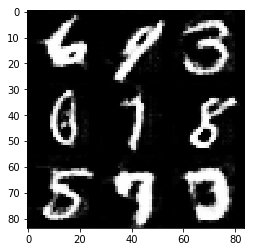

Discriminator Loss: 1.0655 Generator Loss: 0.8856
Discriminator Loss: 0.9257 Generator Loss: 1.4844
Discriminator Loss: 0.9287 Generator Loss: 1.4719
Discriminator Loss: 0.9810 Generator Loss: 1.0470
Discriminator Loss: 1.5277 Generator Loss: 0.4741


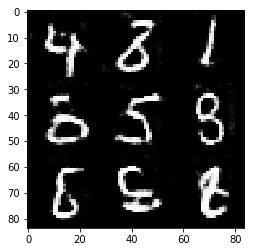

Discriminator Loss: 1.4365 Generator Loss: 0.5133
Discriminator Loss: 1.1011 Generator Loss: 0.9094
Discriminator Loss: 0.9765 Generator Loss: 0.9999
Discriminator Loss: 1.6216 Generator Loss: 0.4342
Discriminator Loss: 1.1675 Generator Loss: 0.9168


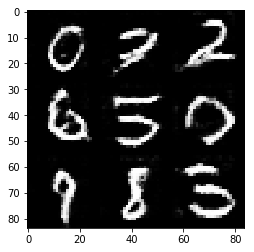

Discriminator Loss: 1.0630 Generator Loss: 0.9482
Discriminator Loss: 1.0807 Generator Loss: 0.8437
Discriminator Loss: 1.0827 Generator Loss: 0.9913
Discriminator Loss: 1.0147 Generator Loss: 1.0355
Discriminator Loss: 1.1878 Generator Loss: 1.1699


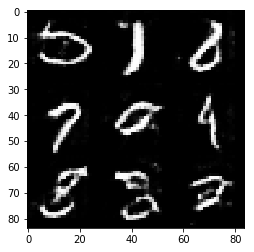

Discriminator Loss: 1.0059 Generator Loss: 1.0183
Discriminator Loss: 1.1042 Generator Loss: 0.8874
Discriminator Loss: 0.8805 Generator Loss: 1.2122
Discriminator Loss: 1.2834 Generator Loss: 0.6683
Discriminator Loss: 1.0108 Generator Loss: 1.7611


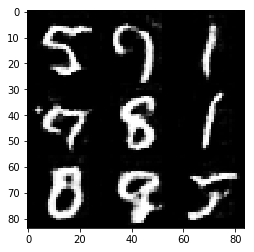

Discriminator Loss: 1.2161 Generator Loss: 0.9477
Discriminator Loss: 1.0219 Generator Loss: 0.9047
Discriminator Loss: 1.0873 Generator Loss: 1.1474
Discriminator Loss: 1.1439 Generator Loss: 0.8843
Discriminator Loss: 1.0112 Generator Loss: 0.8938


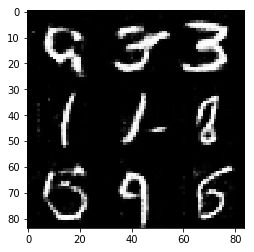

Discriminator Loss: 1.0056 Generator Loss: 1.0698
Discriminator Loss: 0.9069 Generator Loss: 1.2796
Discriminator Loss: 1.3422 Generator Loss: 0.6062
Discriminator Loss: 1.2818 Generator Loss: 0.8898
Discriminator Loss: 1.3968 Generator Loss: 0.7787


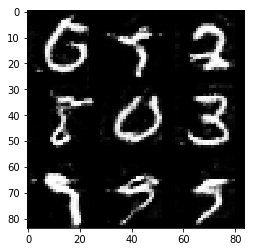

Discriminator Loss: 1.1414 Generator Loss: 0.7710
Discriminator Loss: 0.9888 Generator Loss: 1.0587
Discriminator Loss: 1.1988 Generator Loss: 0.7161
Discriminator Loss: 1.0106 Generator Loss: 1.0193
Discriminator Loss: 1.0949 Generator Loss: 1.2615


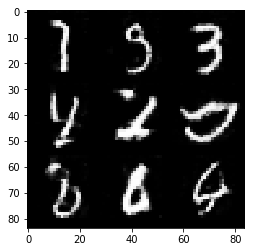

Discriminator Loss: 0.9958 Generator Loss: 1.3065
Discriminator Loss: 1.0651 Generator Loss: 0.9649
Discriminator Loss: 0.8825 Generator Loss: 1.3242
Discriminator Loss: 0.9572 Generator Loss: 1.1542
Discriminator Loss: 1.1007 Generator Loss: 0.9925


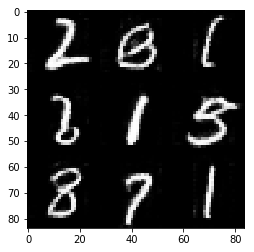

Discriminator Loss: 1.1312 Generator Loss: 1.0538
Discriminator Loss: 0.8739 Generator Loss: 1.0867
Discriminator Loss: 1.0725 Generator Loss: 1.2438
Discriminator Loss: 1.0461 Generator Loss: 1.0415
Discriminator Loss: 0.8716 Generator Loss: 1.4233


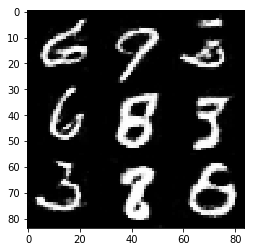

Discriminator Loss: 1.2580 Generator Loss: 0.8691
Discriminator Loss: 0.8646 Generator Loss: 1.5019
Discriminator Loss: 0.9864 Generator Loss: 1.4849
Discriminator Loss: 1.0503 Generator Loss: 1.0170
Discriminator Loss: 1.0016 Generator Loss: 1.0559


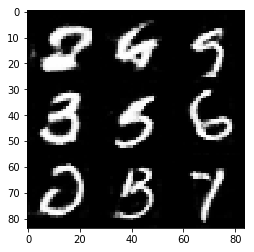

Discriminator Loss: 1.1022 Generator Loss: 0.9151
Discriminator Loss: 0.9306 Generator Loss: 1.3999
Discriminator Loss: 1.0557 Generator Loss: 0.8087
Discriminator Loss: 1.1059 Generator Loss: 1.4388
Discriminator Loss: 1.1822 Generator Loss: 1.2050


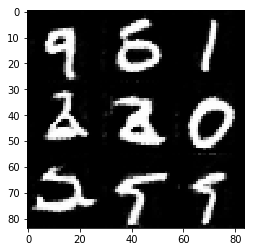

Discriminator Loss: 1.0933 Generator Loss: 1.1604
Discriminator Loss: 1.1747 Generator Loss: 0.7763
Discriminator Loss: 1.1639 Generator Loss: 0.8432
Discriminator Loss: 0.9868 Generator Loss: 1.1575
Discriminator Loss: 1.2234 Generator Loss: 0.7502


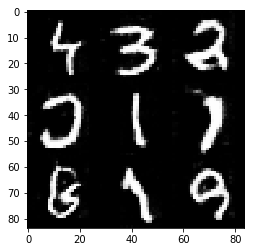

Discriminator Loss: 1.0460 Generator Loss: 0.9484
Discriminator Loss: 1.1825 Generator Loss: 0.8388
Discriminator Loss: 1.0579 Generator Loss: 0.9416
Discriminator Loss: 0.9339 Generator Loss: 1.2517
Discriminator Loss: 1.0814 Generator Loss: 0.9820


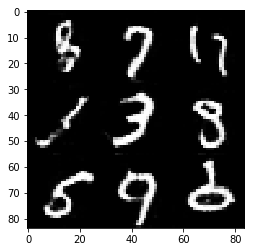

Discriminator Loss: 1.1742 Generator Loss: 0.8638
Discriminator Loss: 1.2207 Generator Loss: 0.8803
Discriminator Loss: 1.2065 Generator Loss: 0.7136
Discriminator Loss: 1.0890 Generator Loss: 1.0852
Discriminator Loss: 1.1551 Generator Loss: 0.7429


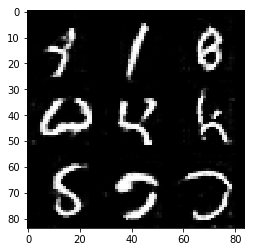

Discriminator Loss: 1.1374 Generator Loss: 0.7475
Discriminator Loss: 1.0513 Generator Loss: 1.0364
Discriminator Loss: 1.1400 Generator Loss: 1.1455
Discriminator Loss: 0.9334 Generator Loss: 1.6160
Discriminator Loss: 1.1599 Generator Loss: 0.9195


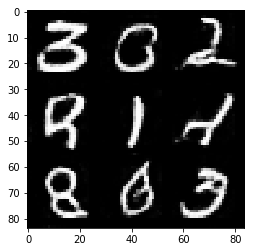

Discriminator Loss: 0.8641 Generator Loss: 1.6788
Discriminator Loss: 0.9201 Generator Loss: 1.2278
Discriminator Loss: 1.0328 Generator Loss: 0.9941
Discriminator Loss: 0.8262 Generator Loss: 1.3155
Discriminator Loss: 1.0498 Generator Loss: 1.0166


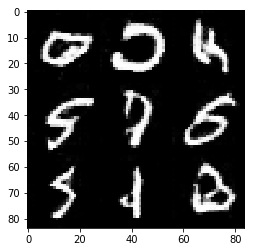

Discriminator Loss: 1.2766 Generator Loss: 0.7824
Discriminator Loss: 1.0311 Generator Loss: 1.1568
Discriminator Loss: 1.0902 Generator Loss: 1.1203
Discriminator Loss: 1.1768 Generator Loss: 0.7826
Discriminator Loss: 1.0555 Generator Loss: 1.2132


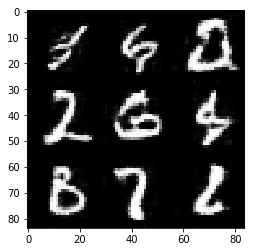

Discriminator Loss: 1.2222 Generator Loss: 1.1364
Discriminator Loss: 1.5663 Generator Loss: 0.4274
Discriminator Loss: 0.9412 Generator Loss: 1.1070
Discriminator Loss: 1.0790 Generator Loss: 0.9829
Discriminator Loss: 1.2000 Generator Loss: 0.7180


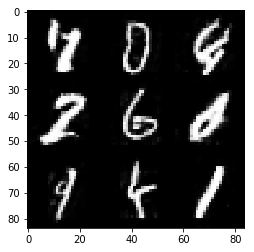

Discriminator Loss: 1.1911 Generator Loss: 1.0979
Discriminator Loss: 1.1269 Generator Loss: 0.7625
Discriminator Loss: 1.2485 Generator Loss: 0.8674


In [29]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Discriminator Loss: 1.3069 Generator Loss: 0.7079
Discriminator Loss: 0.7590 Generator Loss: 1.4115
Discriminator Loss: 0.8676 Generator Loss: 1.2978
Discriminator Loss: 0.7126 Generator Loss: 1.6211


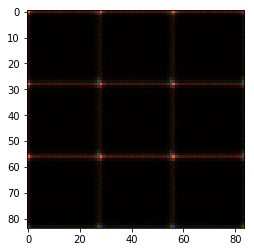

Discriminator Loss: 0.7116 Generator Loss: 1.6621
Discriminator Loss: 0.9522 Generator Loss: 1.2976
Discriminator Loss: 0.8993 Generator Loss: 1.6530
Discriminator Loss: 1.3705 Generator Loss: 0.6072
Discriminator Loss: 1.3952 Generator Loss: 0.5502


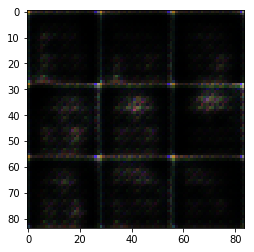

Discriminator Loss: 1.0565 Generator Loss: 1.0577
Discriminator Loss: 0.6751 Generator Loss: 2.2324
Discriminator Loss: 0.7131 Generator Loss: 1.8585
Discriminator Loss: 0.9047 Generator Loss: 1.1339
Discriminator Loss: 0.6630 Generator Loss: 1.7487


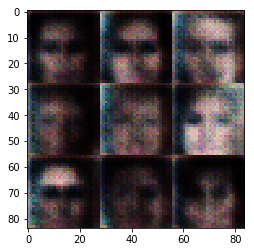

Discriminator Loss: 0.6249 Generator Loss: 2.3430
Discriminator Loss: 0.9035 Generator Loss: 1.2417
Discriminator Loss: 1.2669 Generator Loss: 1.0280
Discriminator Loss: 1.5367 Generator Loss: 0.6402
Discriminator Loss: 0.8761 Generator Loss: 1.5169


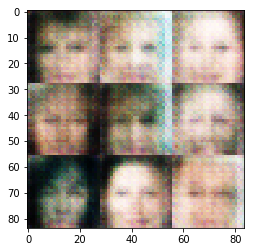

Discriminator Loss: 0.7579 Generator Loss: 2.3088
Discriminator Loss: 1.0415 Generator Loss: 1.2246
Discriminator Loss: 0.7885 Generator Loss: 1.3935
Discriminator Loss: 0.8446 Generator Loss: 1.1550
Discriminator Loss: 0.7421 Generator Loss: 1.9660


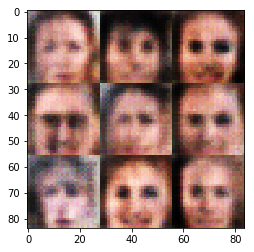

Discriminator Loss: 0.8973 Generator Loss: 1.2979
Discriminator Loss: 1.1259 Generator Loss: 0.9907
Discriminator Loss: 0.6642 Generator Loss: 3.9428
Discriminator Loss: 0.9165 Generator Loss: 1.8066
Discriminator Loss: 1.4030 Generator Loss: 0.6722


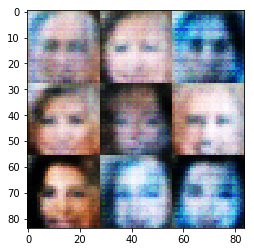

Discriminator Loss: 1.1093 Generator Loss: 1.0177
Discriminator Loss: 1.0836 Generator Loss: 0.7976
Discriminator Loss: 1.2094 Generator Loss: 0.7966
Discriminator Loss: 0.8353 Generator Loss: 1.6809
Discriminator Loss: 0.6375 Generator Loss: 2.2114


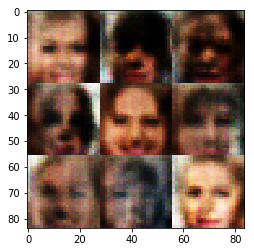

Discriminator Loss: 1.2222 Generator Loss: 0.7350
Discriminator Loss: 0.9412 Generator Loss: 1.4766
Discriminator Loss: 1.0521 Generator Loss: 0.9414
Discriminator Loss: 1.1240 Generator Loss: 1.5619
Discriminator Loss: 0.7951 Generator Loss: 1.2354


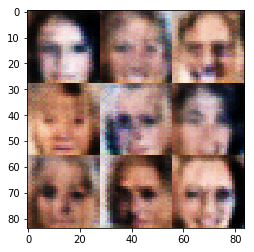

Discriminator Loss: 0.7915 Generator Loss: 1.3152
Discriminator Loss: 0.6614 Generator Loss: 1.6901
Discriminator Loss: 1.0096 Generator Loss: 1.5739
Discriminator Loss: 1.1168 Generator Loss: 1.0795
Discriminator Loss: 1.1410 Generator Loss: 1.5071


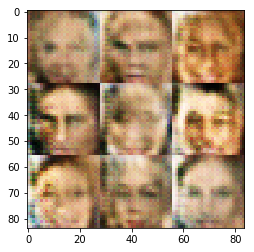

Discriminator Loss: 0.7158 Generator Loss: 2.5930
Discriminator Loss: 1.1245 Generator Loss: 1.0370
Discriminator Loss: 1.0717 Generator Loss: 1.7293
Discriminator Loss: 1.2875 Generator Loss: 0.6994
Discriminator Loss: 1.0679 Generator Loss: 0.8750


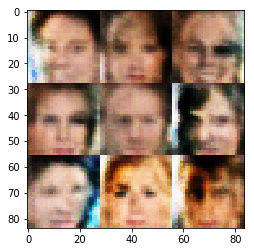

Discriminator Loss: 1.0240 Generator Loss: 1.3822
Discriminator Loss: 0.5947 Generator Loss: 3.5684
Discriminator Loss: 0.9581 Generator Loss: 1.5347
Discriminator Loss: 1.6595 Generator Loss: 1.8252
Discriminator Loss: 0.8675 Generator Loss: 2.3188


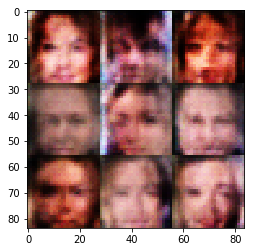

Discriminator Loss: 1.1341 Generator Loss: 1.1603
Discriminator Loss: 0.8707 Generator Loss: 1.8678
Discriminator Loss: 1.2628 Generator Loss: 2.8977
Discriminator Loss: 0.9182 Generator Loss: 1.2317
Discriminator Loss: 1.3947 Generator Loss: 0.7847


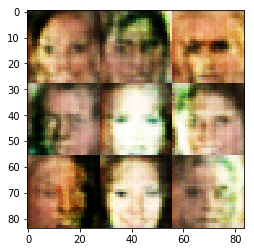

Discriminator Loss: 1.4585 Generator Loss: 0.7462
Discriminator Loss: 1.1777 Generator Loss: 0.7948
Discriminator Loss: 1.3798 Generator Loss: 0.8753
Discriminator Loss: 0.9953 Generator Loss: 1.4256
Discriminator Loss: 1.5551 Generator Loss: 0.5421


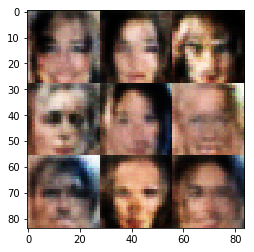

Discriminator Loss: 0.6837 Generator Loss: 1.7041
Discriminator Loss: 0.6973 Generator Loss: 2.2021
Discriminator Loss: 0.6658 Generator Loss: 3.3436
Discriminator Loss: 1.1209 Generator Loss: 0.7905
Discriminator Loss: 0.5124 Generator Loss: 3.1510


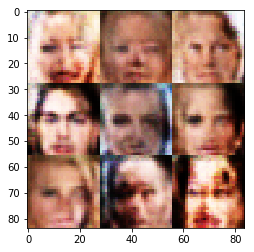

Discriminator Loss: 0.7933 Generator Loss: 1.2216
Discriminator Loss: 0.9641 Generator Loss: 0.8994
Discriminator Loss: 1.0320 Generator Loss: 0.9801
Discriminator Loss: 0.6370 Generator Loss: 2.1389
Discriminator Loss: 1.6906 Generator Loss: 0.4610


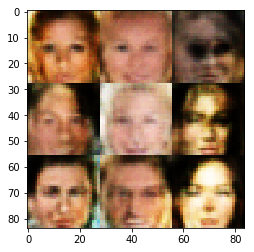

Discriminator Loss: 1.3719 Generator Loss: 0.6352
Discriminator Loss: 1.1269 Generator Loss: 0.8891
Discriminator Loss: 0.8842 Generator Loss: 1.3948
Discriminator Loss: 0.6918 Generator Loss: 2.9541
Discriminator Loss: 1.3501 Generator Loss: 1.4540


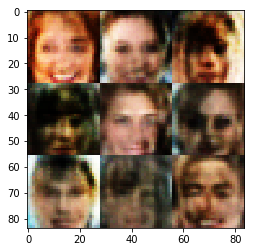

Discriminator Loss: 0.8841 Generator Loss: 2.9131
Discriminator Loss: 0.9281 Generator Loss: 2.0836
Discriminator Loss: 0.7097 Generator Loss: 1.6916
Discriminator Loss: 1.0159 Generator Loss: 2.2211
Discriminator Loss: 0.8580 Generator Loss: 1.1019


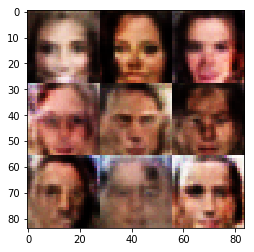

Discriminator Loss: 0.8236 Generator Loss: 1.2245
Discriminator Loss: 0.5357 Generator Loss: 2.5806
Discriminator Loss: 0.7493 Generator Loss: 1.9397
Discriminator Loss: 0.5995 Generator Loss: 1.9714
Discriminator Loss: 0.7019 Generator Loss: 1.4422


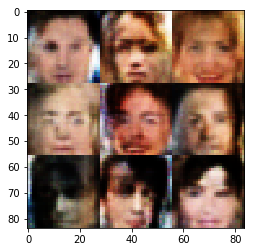

Discriminator Loss: 1.0650 Generator Loss: 0.8974
Discriminator Loss: 0.8451 Generator Loss: 2.5293
Discriminator Loss: 0.9744 Generator Loss: 1.5914
Discriminator Loss: 0.6724 Generator Loss: 2.0399
Discriminator Loss: 1.0962 Generator Loss: 0.7748


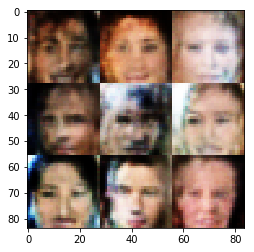

Discriminator Loss: 1.2844 Generator Loss: 0.7986
Discriminator Loss: 1.2265 Generator Loss: 0.8831
Discriminator Loss: 0.7140 Generator Loss: 1.7102
Discriminator Loss: 0.5243 Generator Loss: 2.5168
Discriminator Loss: 0.9864 Generator Loss: 1.4316


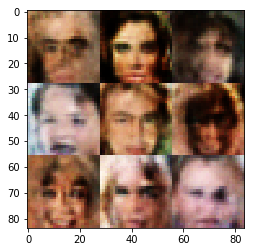

Discriminator Loss: 0.5582 Generator Loss: 2.4003
Discriminator Loss: 0.6154 Generator Loss: 1.7027
Discriminator Loss: 0.6414 Generator Loss: 3.4317
Discriminator Loss: 0.8424 Generator Loss: 2.0029
Discriminator Loss: 1.6729 Generator Loss: 0.3466


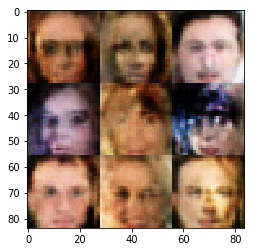

Discriminator Loss: 1.2357 Generator Loss: 0.6624
Discriminator Loss: 0.8187 Generator Loss: 1.1319
Discriminator Loss: 0.5528 Generator Loss: 1.9552
Discriminator Loss: 0.9586 Generator Loss: 1.2283
Discriminator Loss: 1.8691 Generator Loss: 0.3099


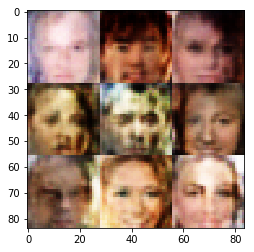

Discriminator Loss: 1.3473 Generator Loss: 0.5095
Discriminator Loss: 0.7094 Generator Loss: 2.0073
Discriminator Loss: 0.5319 Generator Loss: 2.1710
Discriminator Loss: 1.2224 Generator Loss: 0.6300
Discriminator Loss: 0.4664 Generator Loss: 2.4073


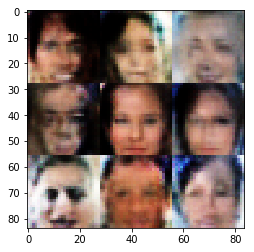

Discriminator Loss: 0.4321 Generator Loss: 3.3295
Discriminator Loss: 1.2958 Generator Loss: 0.6457
Discriminator Loss: 0.5355 Generator Loss: 3.6852
Discriminator Loss: 0.5718 Generator Loss: 2.5422
Discriminator Loss: 0.9830 Generator Loss: 0.8861


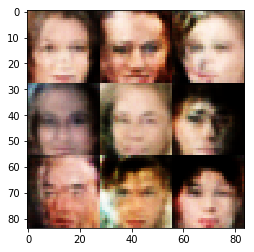

Discriminator Loss: 1.0300 Generator Loss: 0.9729
Discriminator Loss: 1.1418 Generator Loss: 0.8898
Discriminator Loss: 0.8815 Generator Loss: 1.0981
Discriminator Loss: 1.2103 Generator Loss: 0.6400
Discriminator Loss: 1.5151 Generator Loss: 1.0169


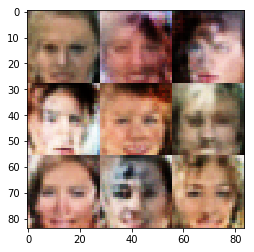

Discriminator Loss: 0.6535 Generator Loss: 2.1148
Discriminator Loss: 0.6123 Generator Loss: 2.0500
Discriminator Loss: 1.5637 Generator Loss: 0.4321
Discriminator Loss: 0.5495 Generator Loss: 2.0549
Discriminator Loss: 0.5777 Generator Loss: 2.2111


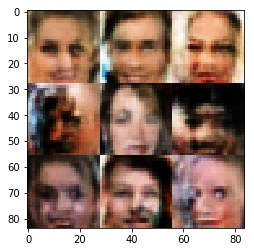

Discriminator Loss: 1.0452 Generator Loss: 0.8613
Discriminator Loss: 0.8948 Generator Loss: 1.0136
Discriminator Loss: 0.8620 Generator Loss: 3.1696
Discriminator Loss: 0.8783 Generator Loss: 1.0469
Discriminator Loss: 0.5131 Generator Loss: 3.7649


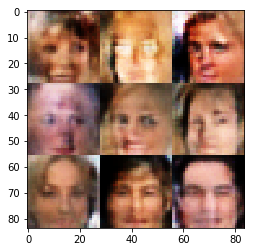

Discriminator Loss: 0.9636 Generator Loss: 1.1465
Discriminator Loss: 1.3623 Generator Loss: 0.8111
Discriminator Loss: 1.0204 Generator Loss: 1.7327
Discriminator Loss: 0.6423 Generator Loss: 1.8230
Discriminator Loss: 1.2126 Generator Loss: 1.6467


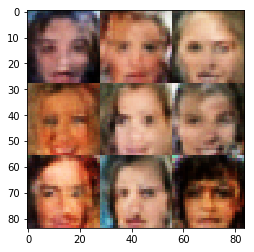

Discriminator Loss: 1.0871 Generator Loss: 0.9504
Discriminator Loss: 1.0068 Generator Loss: 1.0786
Discriminator Loss: 1.0680 Generator Loss: 0.8313
Discriminator Loss: 0.8566 Generator Loss: 3.9791
Discriminator Loss: 0.9650 Generator Loss: 1.0313


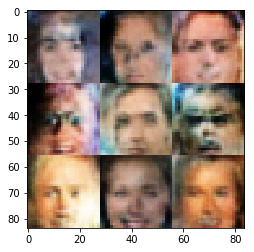

Discriminator Loss: 1.2970 Generator Loss: 0.6006
Discriminator Loss: 0.9890 Generator Loss: 1.6151
Discriminator Loss: 0.5770 Generator Loss: 2.1113
Discriminator Loss: 1.0070 Generator Loss: 0.9144
Discriminator Loss: 0.7731 Generator Loss: 1.5911


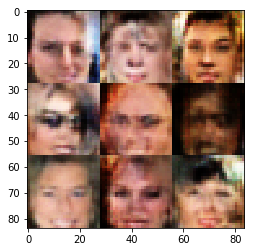

Discriminator Loss: 0.9140 Generator Loss: 1.3860
Discriminator Loss: 0.7480 Generator Loss: 1.4215
Discriminator Loss: 0.6887 Generator Loss: 2.7788
Discriminator Loss: 1.2114 Generator Loss: 2.1137
Discriminator Loss: 0.9346 Generator Loss: 1.5871


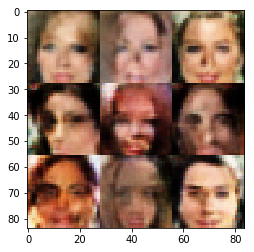

Discriminator Loss: 1.0549 Generator Loss: 1.1729
Discriminator Loss: 1.0138 Generator Loss: 1.1449
Discriminator Loss: 0.8252 Generator Loss: 1.4236
Discriminator Loss: 0.8717 Generator Loss: 1.2741
Discriminator Loss: 0.6544 Generator Loss: 1.9045


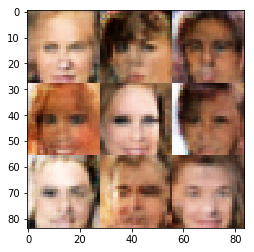

Discriminator Loss: 0.9154 Generator Loss: 1.1885
Discriminator Loss: 0.7319 Generator Loss: 1.5034
Discriminator Loss: 0.9591 Generator Loss: 0.9730
Discriminator Loss: 1.2364 Generator Loss: 0.6310
Discriminator Loss: 0.7224 Generator Loss: 2.7289


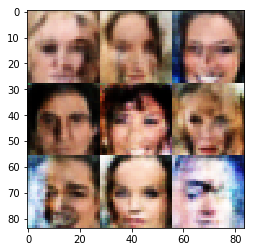

Discriminator Loss: 1.1965 Generator Loss: 1.1423
Discriminator Loss: 1.0430 Generator Loss: 1.3527
Discriminator Loss: 0.9591 Generator Loss: 1.3132
Discriminator Loss: 0.9478 Generator Loss: 1.0646
Discriminator Loss: 1.1350 Generator Loss: 0.8268


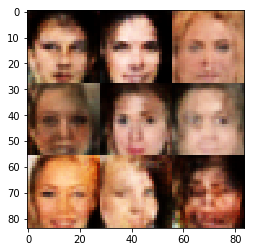

Discriminator Loss: 1.2472 Generator Loss: 0.6771
Discriminator Loss: 1.0013 Generator Loss: 0.9070
Discriminator Loss: 0.7310 Generator Loss: 1.5141
Discriminator Loss: 1.8034 Generator Loss: 0.2981
Discriminator Loss: 0.6373 Generator Loss: 2.8116


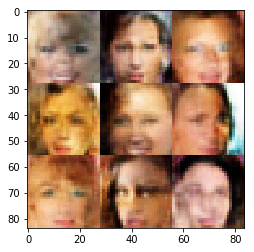

Discriminator Loss: 0.6237 Generator Loss: 2.8110
Discriminator Loss: 1.4512 Generator Loss: 0.5721
Discriminator Loss: 1.4696 Generator Loss: 0.5535
Discriminator Loss: 1.3130 Generator Loss: 2.0634
Discriminator Loss: 0.9101 Generator Loss: 1.7985


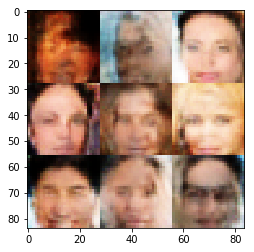

Discriminator Loss: 0.5719 Generator Loss: 1.9556
Discriminator Loss: 0.8877 Generator Loss: 1.6015
Discriminator Loss: 1.0863 Generator Loss: 0.9539
Discriminator Loss: 0.8330 Generator Loss: 1.7298
Discriminator Loss: 0.7868 Generator Loss: 1.4311


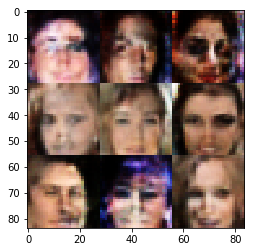

Discriminator Loss: 0.7388 Generator Loss: 1.5984
Discriminator Loss: 0.5093 Generator Loss: 3.0140
Discriminator Loss: 1.1293 Generator Loss: 0.7613
Discriminator Loss: 1.5624 Generator Loss: 1.8065
Discriminator Loss: 1.0487 Generator Loss: 2.6468


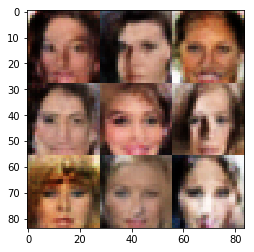

Discriminator Loss: 1.1080 Generator Loss: 0.7311
Discriminator Loss: 1.3664 Generator Loss: 0.7196
Discriminator Loss: 1.3427 Generator Loss: 0.5740
Discriminator Loss: 0.9203 Generator Loss: 1.1991
Discriminator Loss: 0.9258 Generator Loss: 1.1263


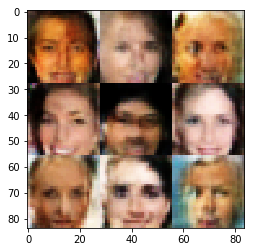

Discriminator Loss: 0.8488 Generator Loss: 1.2921
Discriminator Loss: 1.1672 Generator Loss: 0.8529
Discriminator Loss: 0.8915 Generator Loss: 1.6117
Discriminator Loss: 1.5729 Generator Loss: 0.4136
Discriminator Loss: 0.9119 Generator Loss: 1.3947


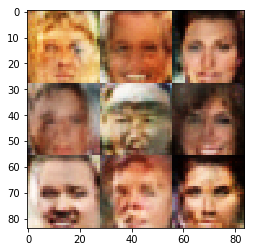

Discriminator Loss: 0.8953 Generator Loss: 1.2299
Discriminator Loss: 1.1476 Generator Loss: 0.6944
Discriminator Loss: 1.0322 Generator Loss: 0.8834
Discriminator Loss: 0.6636 Generator Loss: 1.6405
Discriminator Loss: 0.8910 Generator Loss: 1.1087


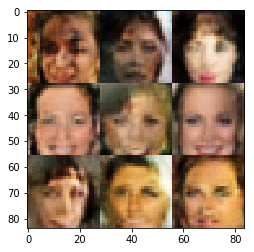

Discriminator Loss: 0.9267 Generator Loss: 1.0267
Discriminator Loss: 1.0560 Generator Loss: 1.3574
Discriminator Loss: 0.8895 Generator Loss: 1.4768
Discriminator Loss: 1.3495 Generator Loss: 0.6122
Discriminator Loss: 0.8875 Generator Loss: 1.2080


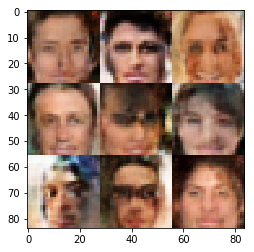

Discriminator Loss: 1.1058 Generator Loss: 0.9588
Discriminator Loss: 0.9243 Generator Loss: 1.1151
Discriminator Loss: 0.9881 Generator Loss: 1.3612
Discriminator Loss: 1.3261 Generator Loss: 1.5925
Discriminator Loss: 1.2295 Generator Loss: 0.6293


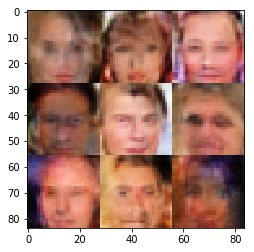

Discriminator Loss: 1.0090 Generator Loss: 0.9416
Discriminator Loss: 1.2518 Generator Loss: 1.1193
Discriminator Loss: 1.1942 Generator Loss: 0.8174
Discriminator Loss: 1.1632 Generator Loss: 1.1233
Discriminator Loss: 1.2228 Generator Loss: 0.6911


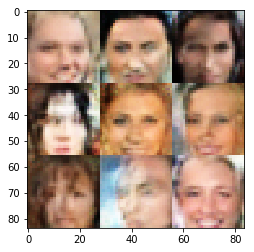

Discriminator Loss: 1.6328 Generator Loss: 0.4170
Discriminator Loss: 1.3317 Generator Loss: 0.6065
Discriminator Loss: 1.2833 Generator Loss: 0.8588
Discriminator Loss: 0.7686 Generator Loss: 1.6778
Discriminator Loss: 0.9503 Generator Loss: 1.1516


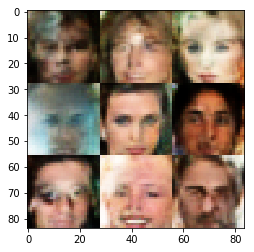

Discriminator Loss: 1.2519 Generator Loss: 0.9550
Discriminator Loss: 0.6503 Generator Loss: 2.2931
Discriminator Loss: 1.0756 Generator Loss: 1.0418
Discriminator Loss: 0.6791 Generator Loss: 1.8978
Discriminator Loss: 2.1467 Generator Loss: 0.2330


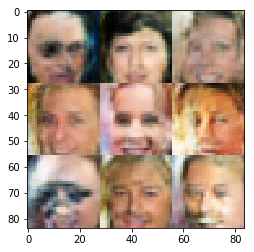

Discriminator Loss: 0.9671 Generator Loss: 0.8815
Discriminator Loss: 1.5884 Generator Loss: 0.4179
Discriminator Loss: 0.9694 Generator Loss: 0.9662
Discriminator Loss: 1.5696 Generator Loss: 0.4461
Discriminator Loss: 1.4185 Generator Loss: 0.5368


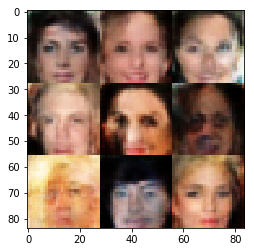

Discriminator Loss: 0.9941 Generator Loss: 0.9038
Discriminator Loss: 0.9609 Generator Loss: 1.0116
Discriminator Loss: 1.8762 Generator Loss: 0.3469
Discriminator Loss: 0.7941 Generator Loss: 1.4098
Discriminator Loss: 0.9877 Generator Loss: 1.0895


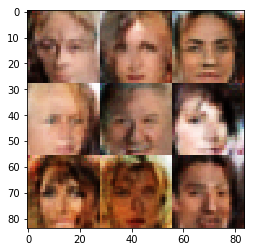

Discriminator Loss: 0.7778 Generator Loss: 1.7176
Discriminator Loss: 0.5049 Generator Loss: 2.7406
Discriminator Loss: 0.7412 Generator Loss: 2.3442
Discriminator Loss: 1.1144 Generator Loss: 0.9560
Discriminator Loss: 0.6907 Generator Loss: 1.7931


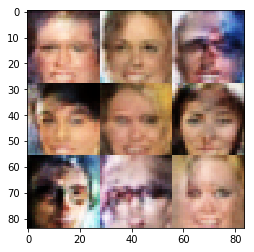

Discriminator Loss: 1.1049 Generator Loss: 0.7438
Discriminator Loss: 0.9433 Generator Loss: 1.0298
Discriminator Loss: 1.1283 Generator Loss: 0.7681
Discriminator Loss: 1.1209 Generator Loss: 0.7952
Discriminator Loss: 1.2919 Generator Loss: 0.6707


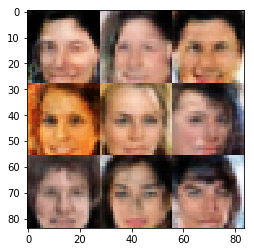

Discriminator Loss: 0.9958 Generator Loss: 0.9653
Discriminator Loss: 1.0330 Generator Loss: 1.5696
Discriminator Loss: 1.2317 Generator Loss: 0.8138
Discriminator Loss: 1.1750 Generator Loss: 0.8411
Discriminator Loss: 0.8502 Generator Loss: 1.2255


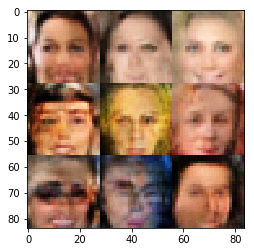

Discriminator Loss: 1.2607 Generator Loss: 0.6836
Discriminator Loss: 1.0132 Generator Loss: 1.2039
Discriminator Loss: 0.9917 Generator Loss: 0.9529
Discriminator Loss: 1.0310 Generator Loss: 1.0740
Discriminator Loss: 0.9010 Generator Loss: 1.4115


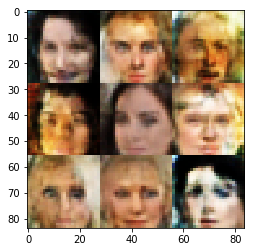

Discriminator Loss: 0.7771 Generator Loss: 1.6666
Discriminator Loss: 0.8520 Generator Loss: 2.2056
Discriminator Loss: 0.9384 Generator Loss: 1.2205
Discriminator Loss: 1.0046 Generator Loss: 1.2383
Discriminator Loss: 0.5868 Generator Loss: 4.5067


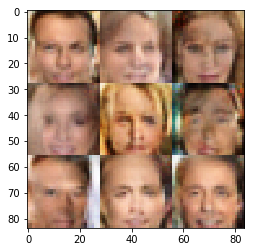

Discriminator Loss: 0.6853 Generator Loss: 2.2571
Discriminator Loss: 1.4083 Generator Loss: 0.5742
Discriminator Loss: 0.8432 Generator Loss: 1.5062
Discriminator Loss: 0.9763 Generator Loss: 1.2233
Discriminator Loss: 1.5682 Generator Loss: 0.4206


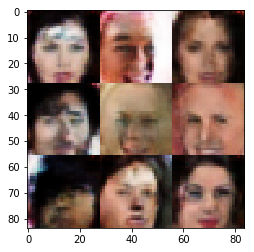

Discriminator Loss: 1.4935 Generator Loss: 0.6138
Discriminator Loss: 0.8025 Generator Loss: 1.2378
Discriminator Loss: 0.8497 Generator Loss: 2.5169
Discriminator Loss: 0.6794 Generator Loss: 3.4586
Discriminator Loss: 1.3750 Generator Loss: 1.5056


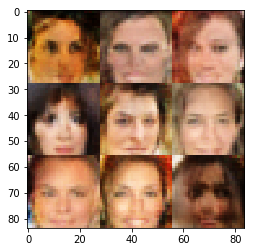

Discriminator Loss: 1.0390 Generator Loss: 1.2302
Discriminator Loss: 1.3515 Generator Loss: 0.6653
Discriminator Loss: 1.2322 Generator Loss: 0.6532
Discriminator Loss: 0.9331 Generator Loss: 1.6669
Discriminator Loss: 1.2797 Generator Loss: 0.6486


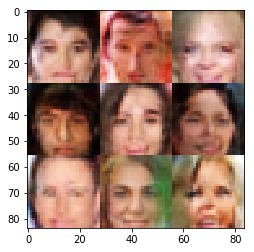

Discriminator Loss: 0.7004 Generator Loss: 1.7679
Discriminator Loss: 1.3277 Generator Loss: 0.5668
Discriminator Loss: 0.9852 Generator Loss: 0.9651
Discriminator Loss: 0.8290 Generator Loss: 1.3719
Discriminator Loss: 1.1183 Generator Loss: 0.8818


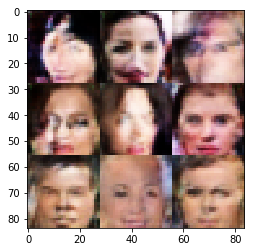

Discriminator Loss: 1.0779 Generator Loss: 0.9484
Discriminator Loss: 1.1526 Generator Loss: 0.8675
Discriminator Loss: 1.3758 Generator Loss: 1.6263
Discriminator Loss: 1.2772 Generator Loss: 0.8173
Discriminator Loss: 1.1965 Generator Loss: 0.6856


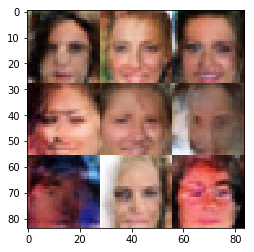

Discriminator Loss: 1.1016 Generator Loss: 0.9372
Discriminator Loss: 1.1362 Generator Loss: 1.1329
Discriminator Loss: 1.1805 Generator Loss: 0.8566
Discriminator Loss: 1.3647 Generator Loss: 0.6560
Discriminator Loss: 0.7226 Generator Loss: 2.0066


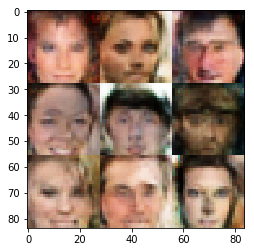

Discriminator Loss: 1.6420 Generator Loss: 0.3740
Discriminator Loss: 1.4278 Generator Loss: 0.6058
Discriminator Loss: 1.0957 Generator Loss: 0.8982
Discriminator Loss: 1.6045 Generator Loss: 0.4185
Discriminator Loss: 1.2228 Generator Loss: 0.7340


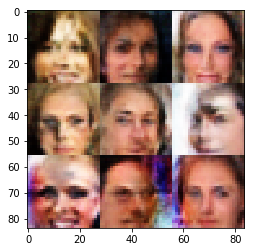

Discriminator Loss: 0.8727 Generator Loss: 1.1344
Discriminator Loss: 1.3024 Generator Loss: 0.7165
Discriminator Loss: 0.9999 Generator Loss: 1.0238
Discriminator Loss: 0.9327 Generator Loss: 1.7246
Discriminator Loss: 1.1420 Generator Loss: 0.7593


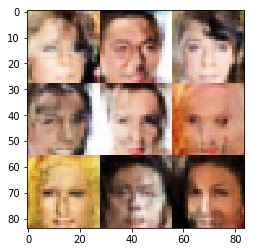

Discriminator Loss: 1.0511 Generator Loss: 1.0452
Discriminator Loss: 1.1157 Generator Loss: 0.8543
Discriminator Loss: 1.0215 Generator Loss: 0.9252
Discriminator Loss: 1.0481 Generator Loss: 0.9478
Discriminator Loss: 1.1393 Generator Loss: 0.7797


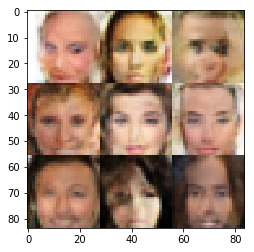

Discriminator Loss: 1.1676 Generator Loss: 0.7247
Discriminator Loss: 1.4102 Generator Loss: 0.6953
Discriminator Loss: 0.8566 Generator Loss: 1.2139
Discriminator Loss: 1.1181 Generator Loss: 0.8351
Discriminator Loss: 0.9917 Generator Loss: 0.9900


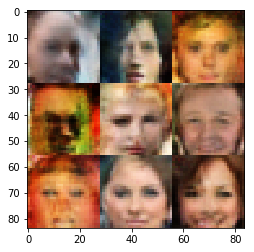

Discriminator Loss: 1.0122 Generator Loss: 1.6749
Discriminator Loss: 1.0957 Generator Loss: 0.7700


In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001

beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.